# Video Game Sales Prediction
---
## Problem Statement
(fill in later)

### Load Libraries & Data

In [171]:
# imports
import pandas as pd
import numpy as np
import requests
import time
import seaborn as sns
from bs4 import BeautifulSoup
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

pd.set_option('display.max_rows', 500)

In [105]:
# load data
video_games = pd.read_csv('../data/video-game-sales.csv')
video_games.columns = video_games.columns.str.lower()
video_games.head()

,name,platform,year_of_release,genre,publisher,na_sales,eu_sales,jp_sales,other_sales,global_sales,critic_score,critic_count,user_score,user_count,developer,rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


## Data Cleaning

In [106]:
# create copy of dataframe
video_games_copy = video_games.copy()

# check data types and null values
video_games_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16717 non-null  object 
 1   platform         16719 non-null  object 
 2   year_of_release  16450 non-null  float64
 3   genre            16717 non-null  object 
 4   publisher        16665 non-null  object 
 5   na_sales         16719 non-null  float64
 6   eu_sales         16719 non-null  float64
 7   jp_sales         16719 non-null  float64
 8   other_sales      16719 non-null  float64
 9   global_sales     16719 non-null  float64
 10  critic_score     8137 non-null   float64
 11  critic_count     8137 non-null   float64
 12  user_score       10015 non-null  object 
 13  user_count       7590 non-null   float64
 14  developer        10096 non-null  object 
 15  rating           9950 non-null   object 
dtypes: float64(9), object(7)
memory usage: 2.0+ MB


In [107]:
# check percentage of missing values
video_games_copy.isnull().mean()*100

name                0.011962
platform            0.000000
year_of_release     1.608948
genre               0.011962
publisher           0.322986
na_sales            0.000000
eu_sales            0.000000
jp_sales            0.000000
other_sales         0.000000
global_sales        0.000000
critic_score       51.330821
critic_count       51.330821
user_score         40.098092
user_count         54.602548
developer          39.613613
rating             40.486871
dtype: float64

In [108]:
video_games_copy.isnull().sum()

name                  2
platform              0
year_of_release     269
genre                 2
publisher            54
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
global_sales          0
critic_score       8582
critic_count       8582
user_score         6704
user_count         9129
developer          6623
rating             6769
dtype: int64

In [109]:
video_games_copy['platform'].value_counts()

PS2     2161
DS      2152
PS3     1331
Wii     1320
X360    1262
PSP     1209
PS      1197
PC       974
XB       824
GBA      822
GC       556
3DS      520
PSV      432
PS4      393
N64      319
XOne     247
SNES     239
SAT      173
WiiU     147
2600     133
NES       98
GB        98
DC        52
GEN       29
NG        12
SCD        6
WS         6
3DO        3
TG16       2
GG         1
PCFX       1
Name: platform, dtype: int64

#### Initial Plan for handling missing data
* Drop all rows with missing names and genre (Reason: can't impute the names, shouldn't effect modeling)
* Drop all rows with gaming platforms that do not exist on metacritic (Reason: Project scope restricted to top consoles / makes data wrangling easier. Small subset of data, so shouldn't effect modeling too much. Restricting top console is makes the data more relevant and descriptive of the problem)
* Scrape missing data from MetaCritic:
   - critic score
   - critic count
   - user score
   - user count
   - developer
   - rating
   - publisher
   - year of release

In [110]:
# Drop rows missing name
video_games_copy.dropna(subset=['name'], inplace=True)

# remove gaming platforms not on metacritics
removed_platforms = ['PCFX', 'GG', 'TG16', '3DO', 'WS', 'SCD', 'NG', 'GEN', 'GB', 'NES', '2600', 'SAT', 'SNES']
video_games_copy = video_games_copy[~video_games_copy['platform'].isin(removed_platforms)]

# List remaining platforms
video_games_copy['platform'].value_counts()

PS2     2161
DS      2152
PS3     1331
Wii     1320
X360    1262
PSP     1209
PS      1197
PC       974
XB       824
GBA      822
GC       556
3DS      520
PSV      432
PS4      393
N64      319
XOne     247
WiiU     147
DC        52
Name: platform, dtype: int64

In [111]:
video_games_copy.isnull().sum().sort_values()

name                  0
platform              0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
global_sales          0
publisher            54
year_of_release     251
developer          5822
user_score         5903
rating             5968
critic_score       7781
critic_count       7781
user_count         8328
dtype: int64

In [112]:
video_games_null = video_games_copy[video_games_copy.isna().any(axis=1)]

### Data Wrangling

In [113]:
# target web page
url = 'https://www.metacritic.com/game'

# establish connection to metacritics website
response = requests.get(url)

# check status code
print(response.status_code)

# pull html string
html = response.text

403


In [114]:
print(html)


<?xml version="1.0" encoding="utf-8"?>
<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Strict//EN"
 "http://www.w3.org/TR/xhtml1/DTD/xhtml1-strict.dtd">
<html>
  <head>
    <title>403 Forbidden</title>
  </head>
  <body>
    <h1>Error 403 Forbidden</h1>
    <p>Forbidden</p>
    <h3>Guru Mediation:</h3>
    <p>Details: cache-dal21252-DAL 1637253089 3467711014</p>
    <hr>
    <p>Varnish cache server</p>
  </body>
</html>



Unable to wrangle data from metacritics. Need explore the data a bit more for a new plan for the missing data.

## Data Cleaning Continued

In [120]:
# recopy the original video games data
video_games_final = video_games.copy()

In [125]:
# convert user_score to float datatype
video_games_final['user_score'] = pd.to_numeric(video_games_final['user_score'], errors="coerce")

In [129]:
# get descriptive stats of video game data
video_games_final.describe().T

,count,mean,std,min,25%,50%,75%,max
year_of_release,16450.0,2006.487356,5.878995,1980.00,2003.00,2007.00,2010.00,2020.00
na_sales,16719.0,0.263330,0.813514,0.00,0.00,0.08,0.24,41.36
eu_sales,16719.0,0.145025,0.503283,0.00,0.00,0.02,0.11,28.96
jp_sales,16719.0,0.077602,0.308818,0.00,0.00,0.00,0.04,10.22
other_sales,16719.0,0.047332,0.186710,0.00,0.00,0.01,0.03,10.57
global_sales,16719.0,0.533543,1.547935,0.01,0.06,0.17,0.47,82.53
critic_score,8137.0,68.967679,13.938165,13.00,60.00,71.00,79.00,98.00
critic_count,8137.0,26.360821,18.980495,3.00,12.00,21.00,36.00,113.00
user_score,7590.0,7.125046,1.500006,0.00,6.40,7.50,8.20,9.70
user_count,7590.0,162.229908,561.282326,4.00,10.00,24.00,81.00,10665.00


**critic score** has a pretty big standard deviation. Need to further explore the distribution of data. The mean and the median are pretty close in value.

**user score** has a low standard deviation. The mean and median are close in value as well.

**critic count** has a big standard deviation. Need to further explore the distribution of data. The mean and median vary in value a bit.

**user count** has a huge standard deviation. Need to further explore the distribution of data. The mean and median vary wildly.

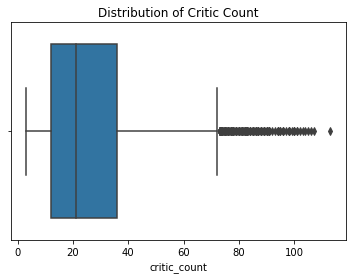

In [140]:
# boxplot for critic count
sns.boxplot(x = video_games_final['critic_count']).set(title="Distribution of Critic Count");

A lot of outliers for the critc count. Best to impute using the median.

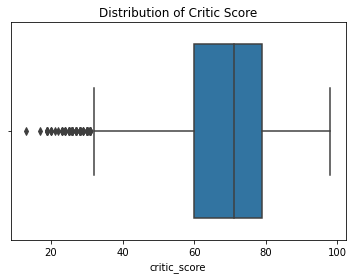

In [141]:
# boxplot for critic score
sns.boxplot(x = video_games_final['critic_score']).set(title="Distribution of Critic Score");

A lot of outliers on the lower end of the spectrum. Best to impute using the median.

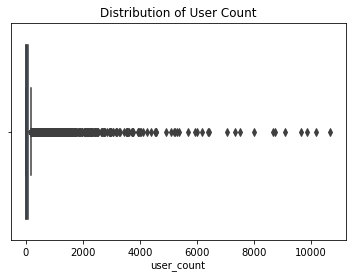

In [142]:
# boxplot for user count
sns.boxplot(x = video_games_final['user_count']).set(title="Distribution of User Count");

A lot of outliers for the user count. Best to impute using the median

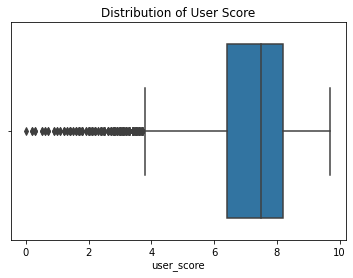

In [146]:
# boxplot for user score
sns.boxplot(x = video_games_final['user_score']).set(title="Distribution of User Score");

A lot of outliers for the user count. Best to impute using the median.

#### New Plan for Handling Missing data
* Drop rows missing name, genre, year of release, and publisher. (Reason: can't wrangle data from metacritic. Droping these rows shouldn't effect modeling too much. Assuming randomized data is missing)
* fill the rows with missing developers with "unknown". (Reason: shouldn't effect modeling. Easiest as not to lose other important data and doesn't make sense to impute with the mode).
* Impute user score, user count, critic score, critic count with median (Reason: each feature contains a large amount of outliers. Using the median shouldn't skew the distribution of the data too much. Better for modeling)
* impute rating with the mode (Reason: Most frequently assigned rating for more than 49% of games [source](https://www.esrb.org/blog/e-for-everyone-continues-to-be-most-frequently-assigned-video-game-rating/))

In [154]:
# Drop missing values in name, genre, year of release, and publisher
video_games_final.dropna(subset=['name', 'genre', 'year_of_release', 'publisher'], inplace=True)

In [157]:
# fill missing values in developer with 'unknown'
video_games_final['developer'].fillna('unknown', inplace=True)

In [168]:
# create numeric and categorical imputers
num_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
cat_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

# split numeric and categorical features
num_columns = video_games_final.select_dtypes(np.number).columns
cat_columns = video_games_final.select_dtypes(object).columns

# split dataframe into numeric and categorical dataframes
num_df = video_games_final.select_dtypes(np.number)
cat_df = video_games_final.select_dtypes(object)

# impute numeric and categorical data
num_imp = num_imputer.fit_transform(num_df)
cat_imp = cat_imputer.fit_transform(cat_df)

# convert imputed data from numpy array to dataframe
num_imp_df = pd.DataFrame(num_imp, columns=num_columns)
cat_imp_df = pd.DataFrame(cat_imp, columns=cat_columns)

# combine imputed numeric and categorical dataframes
video_games_final = pd.concat([cat_imp_df, num_imp_df], axis=1)

video_games_final.head()

,name,platform,genre,publisher,developer,rating,year_of_release,na_sales,eu_sales,jp_sales,other_sales,global_sales,critic_score,critic_count,user_score,user_count
0,Wii Sports,Wii,Sports,Nintendo,Nintendo,E,2006.0,41.36,28.96,3.77,8.45,82.53,76.000000,51.000000,8.0000,322.000000
1,Super Mario Bros.,NES,Platform,Nintendo,unknown,E,1985.0,29.08,3.58,6.81,0.77,40.24,68.997119,26.440992,7.1269,163.008846
2,Mario Kart Wii,Wii,Racing,Nintendo,Nintendo,E,2008.0,15.68,12.76,3.79,3.29,35.52,82.000000,73.000000,8.3000,709.000000
3,Wii Sports Resort,Wii,Sports,Nintendo,Nintendo,E,2009.0,15.61,10.93,3.28,2.95,32.77,80.000000,73.000000,8.0000,192.000000
4,Pokemon Red/Pokemon Blue,GB,Role-Playing,Nintendo,unknown,E,1996.0,11.27,8.89,10.22,1.00,31.37,68.997119,26.440992,7.1269,163.008846


In [170]:
# final check of missing data and data types
video_games_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16416 entries, 0 to 16415
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16416 non-null  object 
 1   platform         16416 non-null  object 
 2   genre            16416 non-null  object 
 3   publisher        16416 non-null  object 
 4   developer        16416 non-null  object 
 5   rating           16416 non-null  object 
 6   year_of_release  16416 non-null  float64
 7   na_sales         16416 non-null  float64
 8   eu_sales         16416 non-null  float64
 9   jp_sales         16416 non-null  float64
 10  other_sales      16416 non-null  float64
 11  global_sales     16416 non-null  float64
 12  critic_score     16416 non-null  float64
 13  critic_count     16416 non-null  float64
 14  user_score       16416 non-null  float64
 15  user_count       16416 non-null  float64
dtypes: float64(10), object(6)
memory usage: 2.0+ MB


In [173]:
# split data into train and test sets
train_set, test_set = train_test_split(video_games_final, test_size=0.20, random_state=42)

# save train and test sets into csv's
train_set.to_csv('../data/train.csv', index=False)
test_set.to_csv('../data/test.csv', index=False)